# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [3]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 20 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [28]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(title = 'title',
             xlabel='Time (days)',
             ylabel='Fraction of population')

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an updated version of `run_simulation` that uses `unpack`.

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [7]:
results, details = run_ode_solver(system, slope_func, max_step = 2)
details

NameError: name 'system' is not defined

**Exercise:** Write a version of `update_func` that uses `unpack`.

In [8]:
# Original

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [9]:
# Solution goes here

Test the updated code with this example.

In [10]:
system = make_system(0.333, 0.25)
results = run_simulation(system, update_func)
results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985230,0.011992,0.002778
2,0.981296,0.012929,0.005776
3,0.977071,0.013921,0.009008
4,0.972541,0.014970,0.012488


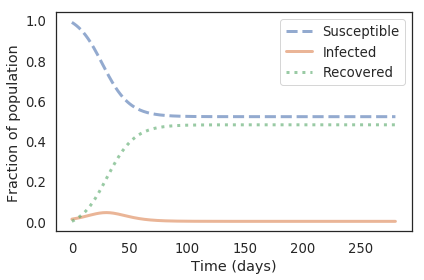

In [11]:
plot_results(results.S, results.I, results.R)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [12]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

0.25

Run the simulation once for each value of `beta` and print total infections.

In [13]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

0.1 0.00723090237276014
0.2 0.038505542746782306
0.30000000000000004 0.3433391671532907
0.4 0.6502882938706543
0.5 0.8045064469467076
0.6 0.8862866368362261
0.7000000000000001 0.9316695085261557
0.8 0.9574278300989798
0.9 0.9720993156353318
1.0 0.9803437149681439
1.1 0.9848347293511588


Wrap that loop in a function and return a `SweepSeries` object.

In [14]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [15]:
infected_sweep = sweep_beta(beta_array, gamma)

,values
0.1,0.007231
0.2,0.038506
0.3,0.343339
0.4,0.650288
0.5,0.804506
0.6,0.886287
0.7,0.931670
0.8,0.957428
0.9,0.972099
1.0,0.980344


Saving figure to file figs/chap06-fig01.pdf


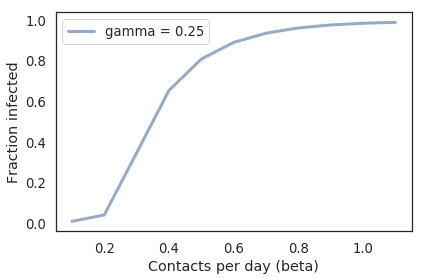

In [16]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('figs/chap06-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [17]:
beta_array

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

And now an array of values for `gamma`

In [18]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

[0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

Saving figure to file figs/chap06-fig02.pdf


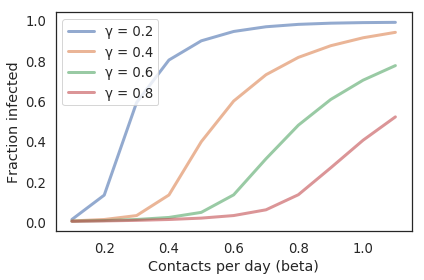

In [19]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'γ = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('figs/chap06-fig02.pdf')

** Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [1]:
# Original

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [20]:
def slope_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: pair of derivatives
    """
    s, i, r = state
    unpack(system)

    dsdt = -beta * i * s 
    didt = beta * i * s - gamma * i
    drdt = gamma * i
    
    print (-dsdt-drdt)
    
    return dsdt, didt, drdt

In [21]:
slope_func(system.init, system.t0, system)

0.009308641975308642


(-0.01208641975308642, 0.009308641975308642, 0.002777777777777778)

In [22]:
system = make_system(0.333, 0.25)

,values
init,S 0.988889 I 0.011111 R 0.000000 dtyp...
t0,0
t_end,280
beta,0.333
gamma,0.25


In [23]:
results, details = run_ode_solver(system, slope_func)
details

0.0008811111111111112
0.0008813860612656584
0.0008821358057072167
0.0008826491670966313
0.0008852147315676138
0.0008856711298699219
0.0008862417106430443
0.0008862416770898632
0.0008964773405748393
0.0009016939898826705
0.0009276456120865862
0.0009323019191101855
0.0009380987604634913
0.0009380671211376293
0.0010384602971833991
0.0010955848044621828
0.0013407499823715873
0.0013854832413115392
0.0014196327362269116
0.0014050368035073112
0.0014810122408866052
0.0014232108542856364
0.0003071510475371412
-0.00020231823419853724
-0.0005362504948246676
-0.00018529546904549714
-0.0008966964598638005
-0.0010533370584059187
-0.0010327856098729105
-6.119970678033528e-05
-8.377580251691264e-05
-0.0007710279728405912
-0.000649801302312578
-0.000811371189312092
-0.0011834456301826179
-0.0009791387460934423
-0.0009927646479895424
-0.0012665837602523324
-0.0011762795210767578
-0.0010916313836452892
-0.0007861313986774225
-0.0010164404242089579
-0.0009899413560950812
-0.0005314093046161119
-0.00119097

,values
sol,None
t_events,[]
nfev,116
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


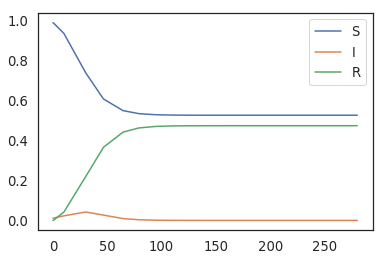

In [24]:
results.plot()

In [25]:
results, details = run_ode_solver(system, slope_func, max_step = 2)
details

0.0008811111111111112
0.0008813860612656584
0.0008821358057072167
0.0008826491670966313
0.0008852147315676138
0.0008856711298699219
0.0008862417106430443
0.0008862416770898632
0.0008964773405748393
0.0009016939898826705
0.0009276456120865862
0.0009323019191101855
0.0009380987604634913
0.0009380671211376293
0.000960836038714814
0.0009726441301506497
0.0010307536112459815
0.0010412848561115657
0.0010541524249139509
0.0010538694459616572
0.001076810535767264
0.001088574330989655
0.001145793225759569
0.0011559552908501055
0.0011683814087316982
0.001168185323894763
0.0011901765493265515
0.0012012773502229814
0.001254365666551782
0.0012635254665576993
0.0012747222210434481
0.0012746343211290341
0.0012942273758819942
0.0013038835394173706
0.0013488182441406104
0.001356217055298134
0.0013652307602811456
0.0013652607335393032
0.0013807184601826363
0.0013880135953800825
0.0014201630151754645
0.0014249611394419864
0.0014307246118477725
0.0014308631263427645
0.0014402612665147677
0.001444207238174

,values
sol,None
t_events,[]
nfev,854
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


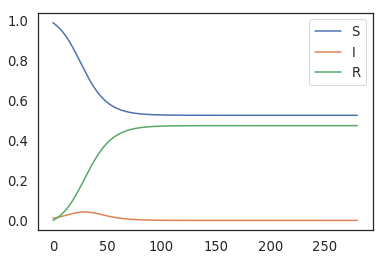

In [26]:
results.plot()